In [2]:
print('Initializing data engineering!')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json, requests, gzip

Initializing data engineering!


### Brazil data engineering

In [3]:
url = 'https://data.brasil.io/dataset/covid19/caso.csv.gz'
response = requests.get(url)
# response.content
with open('/home/rafael/tmp/caso.csv.gz', 'wb') as f:
    f.write(response.content)

In [4]:
with gzip.open('/home/rafael/tmp/caso.csv.gz') as f:
    df = pd.read_csv(f)

In [5]:
df.rename(columns={'confirmed': 'cases', 'estimated_population_2019':'population', 'order_for_place':'day'}, inplace= True)
df['date'] = df['date'].astype('datetime64[ns]')

df = df[(df['city']!='Importados/Indefinidos')]

#apenas cidades de SP e por estados
df = df[((df['state']=='SP') & (df['place_type']=='city')) | (df['place_type']=='state')  ]
# df = df[(df['place_type']=='state')  ]

df.population.fillna(0, inplace=True)
df.city_ibge_code.fillna(0, inplace=True)

df.population = df.population.astype('int')
df.city_ibge_code = df.city_ibge_code.astype('int')

df.drop(columns=['confirmed_per_100k_inhabitants'], inplace=True)
df.fillna('-', inplace=True)

df.sort_values(['state','city','date'], inplace = True)
df.reset_index(inplace = True, drop=True)


# df['week'] = df.date.dt.isocalendar().week 
df['year'] = df.date.dt.year
df['yearMonth'] = df.date.map(lambda x: x.strftime('%Y-%m'))
df['yearWeek'] = df.date.map(lambda x: x.strftime('%y-%V'))
# df['week'] = np.arange(len(df['yearWeek']))

df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,city_ibge_code,death_rate,year,yearMonth,yearWeek
162304,2021-01-21,TO,-,state,98787,1338,310,False,1572866,1590248.0,17,0.0135,2021,2021-01,21-03
162305,2021-01-22,TO,-,state,99290,1344,311,False,1572866,1590248.0,17,0.0135,2021,2021-01,21-03
162306,2021-01-23,TO,-,state,99485,1347,312,False,1572866,1590248.0,17,0.0135,2021,2021-01,21-03
162307,2021-01-24,TO,-,state,99623,1348,313,False,1572866,1590248.0,17,0.0135,2021,2021-01,21-03
162308,2021-01-25,TO,-,state,100204,1353,314,True,1572866,1590248.0,17,0.0135,2021,2021-01,21-04


#### Feature engineering - por semana

In [6]:
print('Iniciando feature engieering Brasil')
inicio = datetime.datetime.now()

states = df.state.unique()
# states = ['SP']
df.drop(df[df['cases'] == 0 ].index, axis=0, inplace= True)

df['perc_death'] = (df['deaths']/df['cases'] * 100).round(2)
df.rename(columns={'order_for_place': 'day'}, inplace= True)

for state in states:
    cities = df[df['state']==state].city.unique()
#     cities = ['Santa Gertrudes']
#     print(datetime.datetime.now().time(), state)
    for city in cities:
        indexes = (df['state']==state) & (df.city == city)
        # valores diários
        df.loc[indexes, 'case_day'] = df[indexes]['cases'].diff()    
        df.loc[indexes, 'death_day'] = df[indexes]['deaths'].diff()

        # Igualo o valor da primeira linha igual ao primeiro número do acumulado, pois se o acumulado começa em 1 o primeiro diff fica igual a 0
        df.loc[(indexes) & (df.day == 1), 'case_day']= df.loc[(indexes) & (df.day==1), 'cases']
        df.loc[(indexes) & (df.day == 1), 'death_day']= df.loc[(indexes) & (df.day==1), 'deaths']

#         % daily variations
        df.loc[indexes, 'var_case_day'] = ((df[indexes]['case_day'].diff())) #/ df[indexes]['case_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
        df.loc[indexes, 'var_death_day'] = ((df[indexes]['death_day'].diff())) #/ df[indexes]['death_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
        df.loc[indexes, 'perc_var_death_day'] = ((df[indexes]['death_day'].shift()-df[indexes]['death_day'])/ df[indexes]['death_day'].shift()) #/ df[indexes]['death_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)

        # Buscando a população do estado/cidade e calculado os indicador per milhar
        if not df[indexes].population.empty:
            thousand = df[indexes]['population'] / 1000
            cases_thousand = (df[indexes]['cases'] / thousand)
            deaths_thousand = (df[indexes]['deaths'] / thousand)
            case_day_thousand = (df[indexes]['case_day'] / thousand)
            death_day_thousand = (df[indexes]['death_day'] / thousand)
        else:
            cases_thousand = 0
            deaths_thousand = 0
            case_day_thousand = 0
            death_day_thousand = 0
            
        df.loc[indexes, 'cases_thousand'] = cases_thousand
        df.loc[indexes, 'deaths_thousand'] = deaths_thousand
        df.loc[indexes, 'case_day_thousand'] = case_day_thousand
        df.loc[indexes, 'death_day_thousand'] = death_day_thousand
        
        df.loc[indexes, 'avg7_deaths'] = df[indexes]['death_day'].rolling(window=7).mean()
        df.loc[indexes, 'avg7_death_day_thousand'] = df[indexes]['death_day_thousand'].rolling(window=7).mean()

#         df.loc[indexes, 'death_day_medio']= df[indexes]['death_day'].expanding().mean()


df.fillna(0, inplace=True)

df['case_day'] = df['case_day'].astype('int')
df['death_day'] = df['death_day'].astype('int')


df['cases_thousand'] = df['cases_thousand'].round(3)
df['deaths_thousand'] = df['deaths_thousand'].round(3)
df['case_day_thousand'] = df['case_day_thousand'].round(3)
df['death_day_thousand'] = df['death_day_thousand'].round(3)


df['cases'] = df['case_day']
df['deaths'] = df['death_day']


termino = datetime.datetime.now()
print('finalizado em ', termino-inicio)
df[indexes].tail()

Iniciando feature engieering Brasil
finalizado em  0:00:31.701283


,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,yearWeek,perc_death,case_day,death_day,var_case_day,var_death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand
162304,2021-01-21,TO,-,state,535,4,310,False,1572866,1590248.0,...,21-03,1.35,535,4,73.0,0.0,62.807,0.851,0.340,0.003
162305,2021-01-22,TO,-,state,503,6,311,False,1572866,1590248.0,...,21-03,1.35,503,6,-32.0,2.0,63.127,0.854,0.320,0.004
162306,2021-01-23,TO,-,state,195,3,312,False,1572866,1590248.0,...,21-03,1.35,195,3,-308.0,-3.0,63.251,0.856,0.124,0.002
162307,2021-01-24,TO,-,state,138,1,313,False,1572866,1590248.0,...,21-03,1.35,138,1,-57.0,-2.0,63.339,0.857,0.088,0.001
162308,2021-01-25,TO,-,state,581,5,314,True,1572866,1590248.0,...,21-04,1.35,581,5,443.0,4.0,63.708,0.860,0.369,0.003


In [7]:
# df2 =  df.groupby(['state','city','yearMonth'], sort=True).agg({
# df2 =  df.groupby(['week'], sort=True).agg({

dados = df.copy()
# dados = df.loc[(df['state']=='PR') & (df ['place_type']=='state')]
# dados = df.loc[(df['city']=='São Paulo') & (df ['place_type']=='city')]
# dados = df.loc[(df['city']=='Lucélia') & (df ['place_type']=='city')]

df2 =  dados.groupby(['yearMonth'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'var_case_day': 'mean',
        'var_death_day':'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'perc_var_death_day':'mean',
})


df3 =  dados.groupby(['yearWeek'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'var_case_day': 'mean',
        'var_death_day':'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'perc_var_death_day':'mean'
})

df3.reset_index(drop=True, inplace=True) #só para ficar com uma lista de números incrementais
df3.head()

df2.tail()

,cases,deaths,case_day,death_day,var_case_day,var_death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand
yearMonth,,,,,,,,,,
2020-09,1083805,27954,55.545562,1.432657,-0.623052,0.021320,0.158240,0.003993,16.156894,0.401138
2020-10,850880,19697,50.187566,1.161791,-1.159431,-0.038339,0.122494,0.003422,20.020276,0.509847
2020-11,929720,16080,57.118634,0.987897,0.339497,-0.004853,0.097133,0.002291,22.618210,0.576382
2020-12,1559700,26426,91.968866,1.558229,3.046111,0.068872,0.173677,0.003126,25.765073,0.632861
2021-01,1499472,28776,136.105292,2.611963,-1.064990,-0.027866,0.335367,0.005616,31.099781,0.729035


In [8]:
# df.to_csv('../data/brazil_states_corona19_data.csv', index = True)

In [9]:
df2['deaths_mean']= df2.deaths.expanding().mean()
df2['death_thousand_mean']= df2.deaths_thousand.expanding().mean()
df2['death_day_mean']= df2.death_day.expanding().mean()
df2['death_day_thousand_mean']= df2.death_day_thousand.expanding().mean()

df3['deaths_mean']= df3.deaths.expanding().mean()
df3['death_thousand_mean']= df3.deaths_thousand.expanding().mean()
df3['death_day_mean']= df3.death_day.expanding().mean()
df3['death_day_thousand_mean']= df3.death_day_thousand.expanding().mean()

df2.tail()

,cases,deaths,case_day,death_day,var_case_day,var_death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand,deaths_mean,death_thousand_mean,death_day_mean,death_day_thousand_mean
yearMonth,,,,,,,,,,,,,,
2020-09,1083805,27954,55.545562,1.432657,-0.623052,0.021320,0.158240,0.003993,16.156894,0.401138,22448.250000,0.123935,1.361002,0.002084
2020-10,850880,19697,50.187566,1.161791,-1.159431,-0.038339,0.122494,0.003422,20.020276,0.509847,22142.555556,0.166814,1.338867,0.002233
2020-11,929720,16080,57.118634,0.987897,0.339497,-0.004853,0.097133,0.002291,22.618210,0.576382,21536.300000,0.207771,1.303770,0.002238
2020-12,1559700,26426,91.968866,1.558229,3.046111,0.068872,0.173677,0.003126,25.765073,0.632861,21980.818182,0.246415,1.326903,0.002319
2021-01,1499472,28776,136.105292,2.611963,-1.064990,-0.027866,0.335367,0.005616,31.099781,0.729035,22547.083333,0.286634,1.433991,0.002594


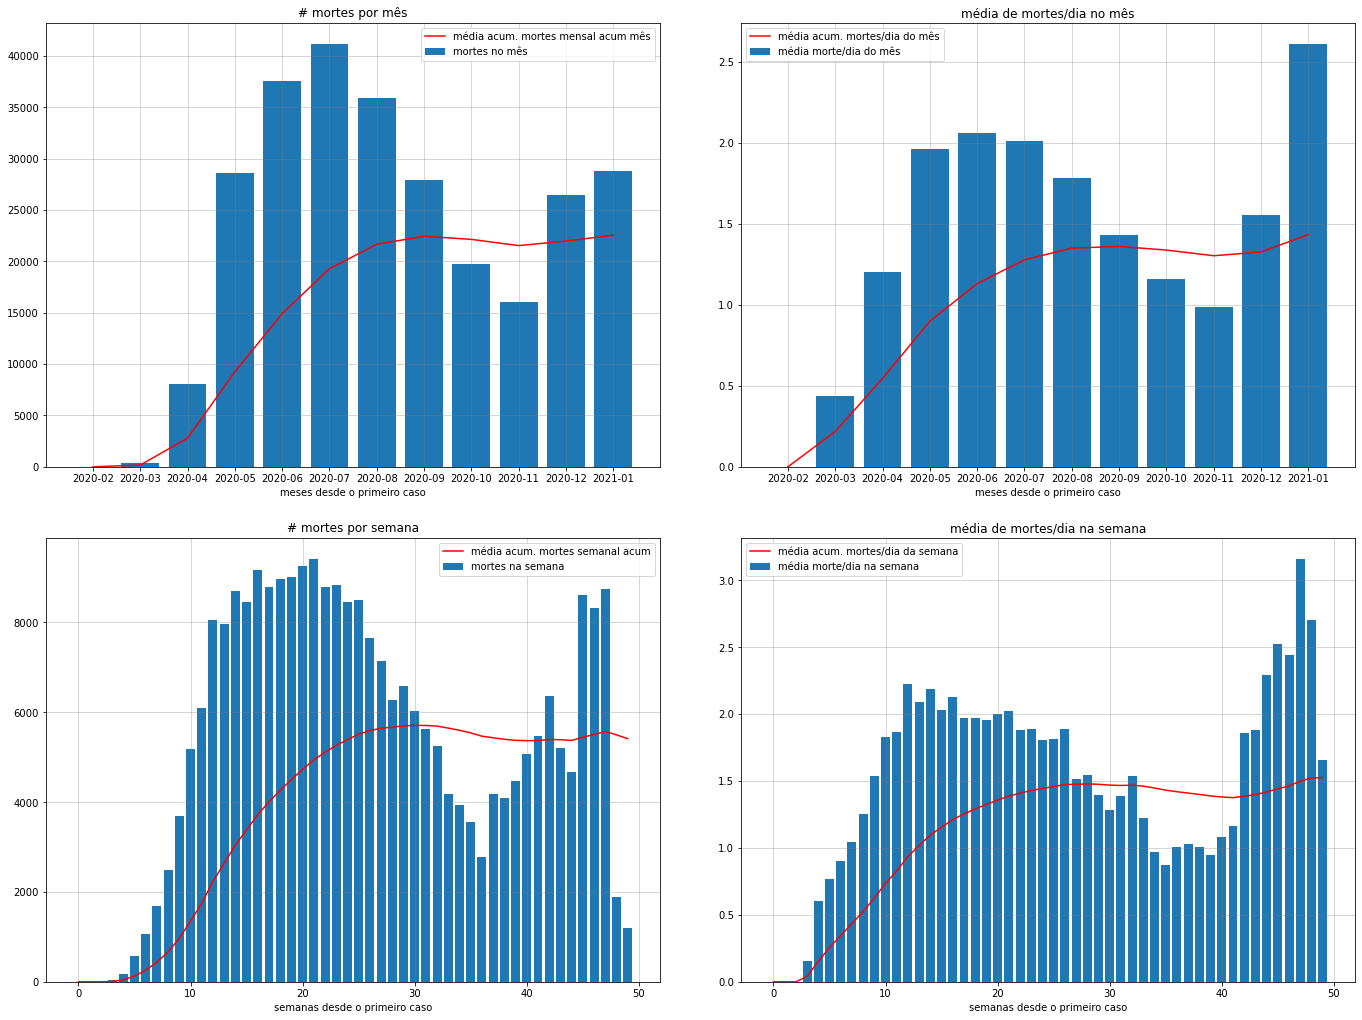

In [10]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("# mortes por mês")
ax1.set_xlabel("meses desde o primeiro caso")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("média de mortes/dia no mês")
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("# mortes por semana")
ax3.set_xlabel("semanas desde o primeiro caso")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("média de mortes/dia na semana")
ax4.set_xlabel("semanas desde o primeiro caso")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)


ax1.bar(df2.index, df2.deaths, label='mortes no mês')
ax1.plot(df2.index, df2['deaths_mean'],  label='média acum. mortes mensal acum mês', color='red')

ax2.bar(df2.index, df2.death_day, label='média morte/dia do mês')
ax2.plot(df2.index, df2['death_day_mean'],  label='média acum. mortes/dia do mês', color='red')


ax3.bar(df3.index, df3.deaths, label='mortes na semana')
ax3.plot(df3.index, df3['deaths_mean'],  label='média acum. mortes semanal acum', color='red')

ax4.bar(df3.index, df3.death_day, label='média morte/dia na semana')
ax4.plot(df3.index, df3['death_day_mean'],  label='média acum. mortes/dia da semana', color='red')


# ax2.plot(dados.day, dados.avg7_cases, label = state)
# ax3.plot(dados.day, dados.deaths, label = state)
# ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
fig.savefig('../analysis/temp.png')

In [13]:
state_geo = json.load(open('../data/brasil-estados.json'))
df_mapa = df[df.is_last == True].copy()#df[(df['date']==str(today))].copy()
states = df_mapa.state.unique()

for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lat'] = latLon[1]
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lon'] = latLon[0]

df_mapa.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,case_day,death_day,var_case_day,var_death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand,lat,lon
161324,2021-01-25,SP,Álvares Florence,city,1,0,213,True,3679,3647.0,...,1,0,0.0,0.0,33.977,1.903,0.272,0.000,NaN,NaN
161568,2021-01-25,SP,Álvares Machado,city,0,0,244,True,24915,24998.0,...,0,0,0.0,0.0,21.674,0.602,0.000,0.000,NaN,NaN
161802,2021-01-25,SP,Álvaro de Carvalho,city,0,0,234,True,5227,5274.0,...,0,0,-6.0,0.0,12.053,0.765,0.000,0.000,NaN,NaN
161994,2021-01-25,SP,Óleo,city,0,0,192,True,2496,2471.0,...,0,0,-1.0,0.0,6.410,0.000,0.000,0.000,NaN,NaN
162308,2021-01-25,TO,-,state,581,5,314,True,1572866,1590248.0,...,581,5,443.0,4.0,63.708,0.860,0.369,0.003,-10.15,-48.32916
